<a href="https://www.kaggle.com/code/sagorkumarmitra/medical-image-classification-with-pytorch?scriptVersionId=212745737" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Library

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# File Directory

In [2]:
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images
# /kaggle/input/rsna-pneumonia-detection-challenge/GCP Credits Request Link - RSNA.txt
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv

# Preprocessing The Images

In [3]:
labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [4]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [5]:
labels = labels.drop_duplicates('patientId')

In [6]:
labels.patientId.iloc[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [7]:
ROOT_PATH = Path('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('/kaggle/working/Processed')

# Sample Image Visualization

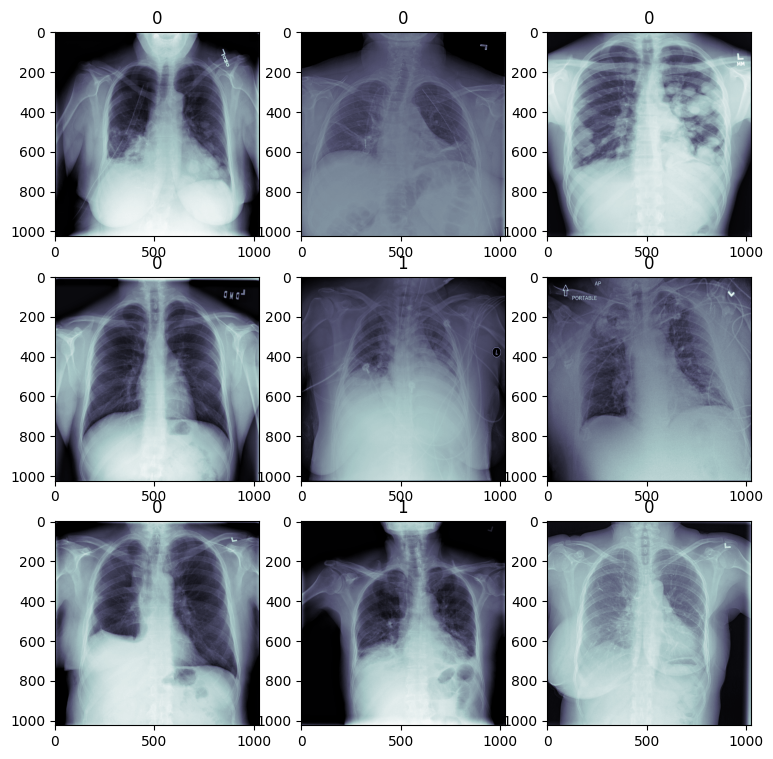

In [8]:
fig, axis = plt.subplots(3,3,figsize=(9,9))
c=0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels['Target'].iloc[c]
        axis[i][j].imshow(dcm,cmap='bone')
        axis[i][j].set_title(label)
        c += 1

# Normalization

In [9]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255

    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)
    label = labels.Target.iloc[c]
    train_or_val = 'train' if c < 24000 else 'val'

    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True,exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 224 * 224
    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [10]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [11]:
mean, std

(0.4903962485384803, 0.24795070634161256)

# Train

In [12]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [14]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248),
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),
    transforms.RandomResizedCrop((224,224),scale=(0.35,1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248),
])

In [15]:
train_dataset = torchvision.datasets.DatasetFolder('/kaggle/working/Processed/train/',loader=load_file, extensions='npy',transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder('/kaggle/working/Processed/val/',loader=load_file, extensions='npy',transform=val_transforms)

In [16]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: /kaggle/working/Processed/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.49, std=0.248)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

In [17]:
x_ray, label = train_dataset[0]

In [18]:
x_ray

tensor([[[-1.9442, -1.9442, -1.9442,  ...,  0.0000,  0.0000,  0.0000],
         [-1.9442, -1.9442, -1.9442,  ...,  0.0000,  0.0000,  0.0000],
         [-1.9442, -1.9442, -1.9449,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.5849, -0.5102, -0.4103,  ..., -1.9435, -1.9712, -1.9758],
         [-0.5644, -0.4911, -0.3957,  ..., -1.9590, -1.9758, -1.9758],
         [-0.5494, -0.4744, -0.3831,  ..., -1.9693, -1.9758, -1.9758]]])

In [19]:
type(x_ray)

torch.Tensor

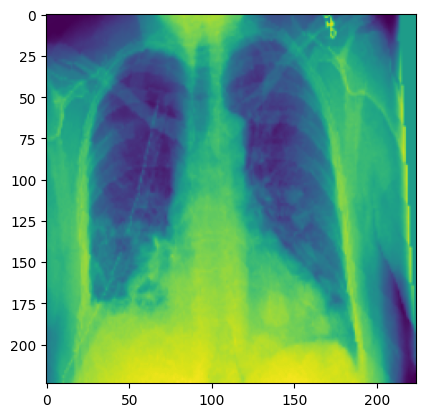

In [20]:
plt.imshow(x_ray[0])

In [21]:
label

0

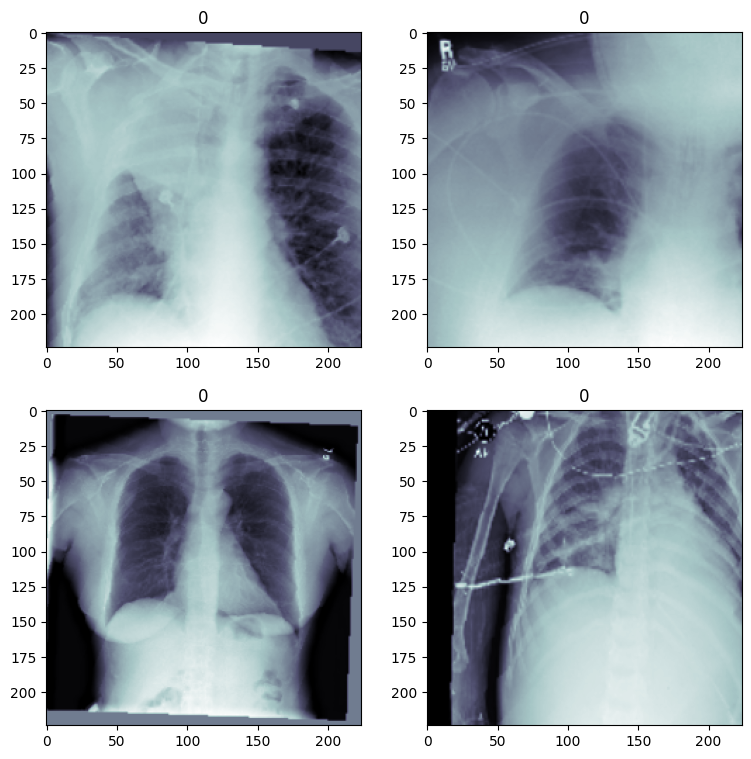

In [22]:
fig, axis = plt.subplots(2,2,figsize=(9,9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,24000)
        x_ray, labek = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0],cmap='bone')
        axis[i][j].set_title(label)

In [23]:
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)

In [24]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

There we see Class: 0 contains 18,593 images and Class: 1 contains 5,407 images which is far small. So the dataset is imbalanced. We can handle the situation in three ways:

* Do nothing
* Awaited Loss Fucntion
* Over Sampling

# Model

In [25]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# class PneumoniaModel(pl.LightningModule):

#     def __init__(self):
#         super().__init__()
        
#         self.model = torchvision.models.resnet18()
#         self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
#         self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

#         self.train_acc = torchmetrics.Accuracy()
#         self.val_acc = torchmetrics.Accuracy()

#     def forward(self, data):
#         pred = self.model(data)
#         return pred

#     def training_step(self, batch, batch_idx):
#         x_ray, label = batch
#         label = label.float()
#         pred = self(x_ray)[:,0]
#         loss = self.loss_fn(pred,label)

#         self.log("Train Loss", loss)
#         self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

#         return loss

#     def training_epoch_end(self,outs):
#         self.log("Train ACC", self.train_acc.compute())
#         self.train_acc.reset()

#     def validation_step(self, batch, batch_idx):
#         x_ray, label = batch
#         label = label.float()
#         pred = self(x_ray)[:,0]
#         loss = self.loss_fn(pred,label)

#         self.log("Val Loss", loss)
#         self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))


#     def validation_epoch_end(self,outs):
#         self.log("Val ACC", self.val_acc.compute())
#         self.val_acc.reset()

#     def configure_optimizers(self):
#         return [self.optimizer]

In [27]:
import pytorch_lightning as pl
import torch
import torchvision
import torchmetrics

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()  # Call the parent class constructor
        
        # Define the model
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        # Define optimizer and loss function
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))
        
        # Define metrics for binary classification
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))

    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        return self.optimizer


In [28]:
model = PneumoniaModel()

In [29]:
model

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [30]:
[0] * 5

[0, 0, 0, 0, 0]

In [31]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'Val ACC',
    save_top_k=10,
    mode='max'
)

In [32]:
gpus = 1
trainer = pl.Trainer( logger=TensorBoardLogger(save_dir='./logs'),
                    log_every_n_steps=1,callbacks=checkpoint_callback,max_epochs=10)

In [33]:
trainer.fit(model,train_loader,val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = PneumoniaModel.load_from_checkpoint('/kaggle/working/logs/lightning_logs/version_0/checkpoints/epoch=9-step=3750.ckpt')
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [35]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [36]:
# /kaggle/working/Processed/val/0/0053ee32-1e03-4dc2-a103-f46ad0448787.npy

In [37]:
preds[:10]

tensor([0.1792, 0.0094, 0.0213, 0.1771, 0.2096, 0.1157, 0.4415, 0.0956, 0.0118,
        0.3927])

In [38]:
labels[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [39]:
acc= torchmetrics.Accuracy(task="binary")(preds,labels)
precision = torchmetrics.Precision(task="binary")(preds,labels)
recall = torchmetrics.Recall(task="binary")(preds,labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2,task="binary")(preds,labels)

In [40]:
acc

tensor(0.7865)

In [41]:
precision

tensor(0.5170)

In [42]:
recall

tensor(0.8050)

In [43]:
cm

tensor([[1624,  455],
        [ 118,  487]])